In [1]:
from post_processing import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
filename = r"D:\EIT\EIT_Thigh_Force_Measurement\GUI_Data_Acquisition\measurements\Judi_t_20250207_084859\Test_3_AW_raw_data_12012025091939.txt"
output_path = "/Users/arash/Desktop/Uni_semester/Master_Thesis/Codes/Participant_test1/iso_raw_test1.csv"

In [ ]:

iso_raw_DF = generate_DF(file_path=filename, output_path=output_path)


## Plot the Torque , Speed, Angle from isoforce DF

Applying low-pass filter to torque and angle data.


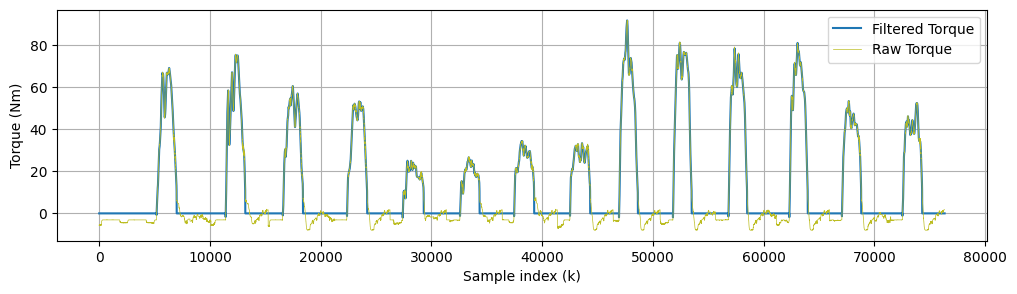

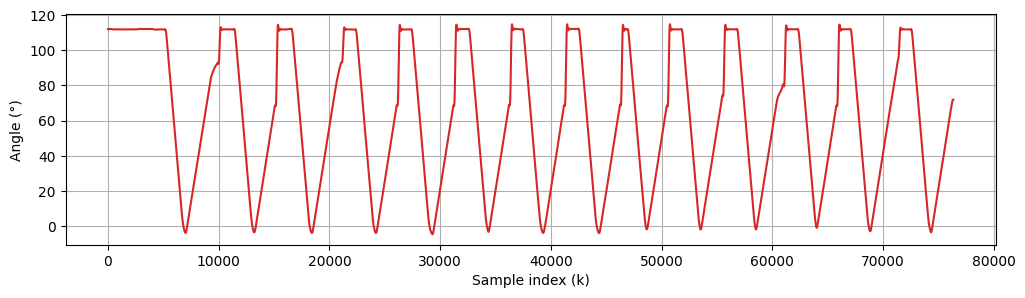

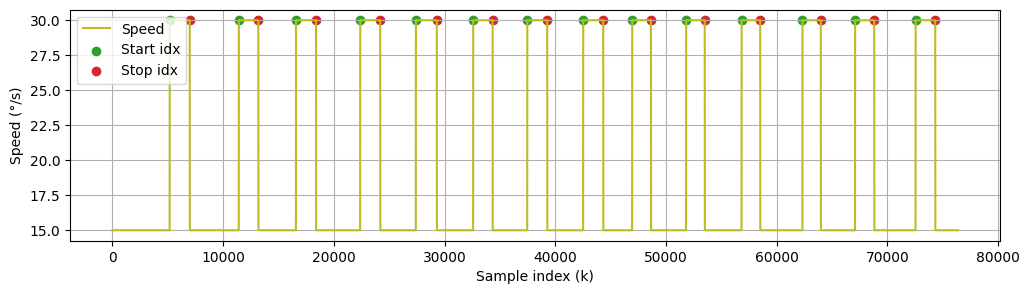

In [3]:
import pandas as pd
iso_raw_DF = r"D:\EIT\EIT_Thigh_Force_Measurement\GUI_Data_Acquisition\measurements\Judi_t_20250207_084859\iso_raw_data.csv"
iso_raw_DF = pd.read_csv(iso_raw_DF)
isoforce_iso = IsoForceRAW(iso_raw_DF, LP_filter_enabled=True)
isoforce_iso.plot_torque()
isoforce_iso.plot_angle()
isoforce_iso.plot_speed()

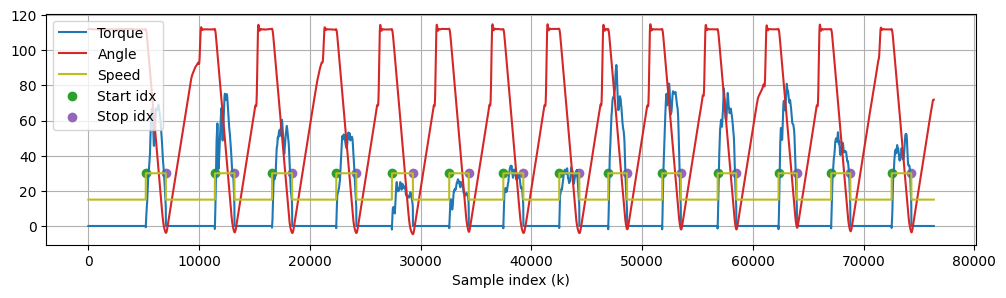

In [4]:
isoforce_iso.plot_data()


## Plot segmented Torque and angle from isoforce DF

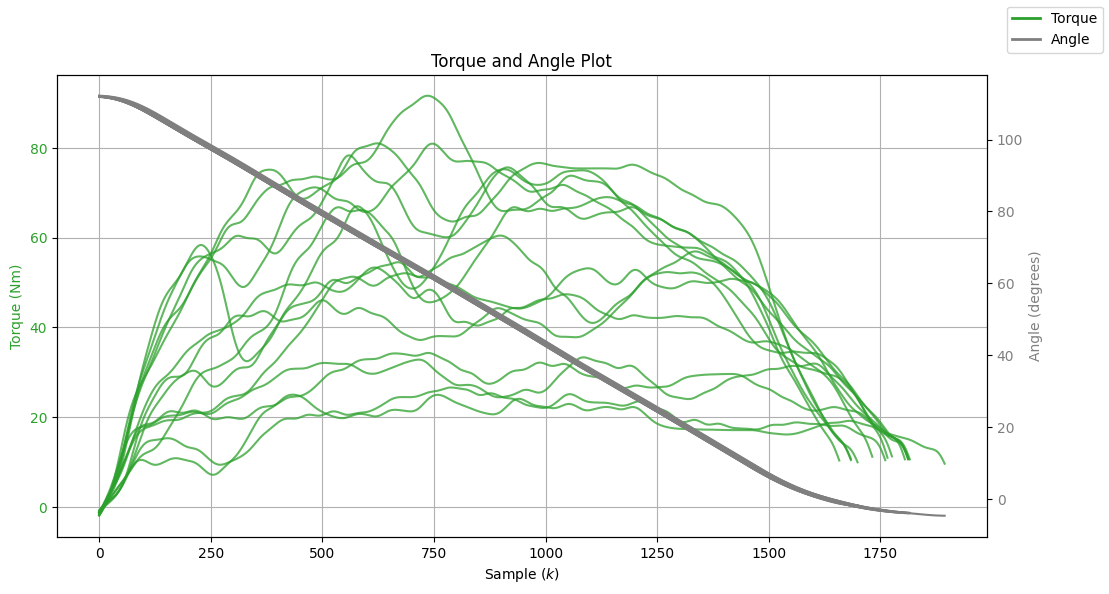

In [5]:
from matplotlib.lines import Line2D
fig, ax1 = plt.subplots(figsize=(12,6)) 

# Plot Torque on the primary y-axis
for idx in range(len(isoforce_iso.torque_segments.keys())):
    ax1.plot(isoforce_iso.torque_segments[f"T_seg_{idx}"], "C2", alpha=0.75)

ax1.set_xlabel("Sample ($k$)")
ax1.set_ylabel("Torque (Nm)", color="C2")
ax1.tick_params(axis="y", labelcolor="C2")
ax1.grid()

# Create a second y-axis for Angle
ax2 = ax1.twinx()  
for idx in range(len(isoforce_iso.angle_segments.keys())):
    ax2.plot(isoforce_iso.angle_segments[f"A_seg_{idx}"], "C7")

ax2.set_ylabel("Angle (degrees)", color="C7")
ax2.tick_params(axis="y", labelcolor="C7")

custom_lines = [
    Line2D([0], [0], color="C2", lw=2, label="Torque"),
    Line2D([0], [0], color="C7", lw=2, label="Angle")
]
fig.legend(handles=custom_lines, loc="upper right")


plt.title("Torque and Angle Plot")
plt.show()


# Isoforce Data Acquisition from NI Chip

The NI chip is equipped with three channels: P, T, and S. Each channel is associated with specific measurement parameters, including a factor and offset, as detailed below:

- **Channel 1 (P):** Angle  
  - Factor: 54  
  - Offset: 12  

- **Channel 2 (T):** Torque  
  - Factor: 150  
  - Offset: 25  

- **Channel 3 (S):** Speed  
  - Factor: 108  
  - Offset: -3  


In [6]:
import os
#base_path_NI = r"D:\EIT\EIT_Thigh_Force_Measurement\GUI_Data_Acquisition\measurements\Participant_test1"
base_path_NI = r"D:\EIT\EIT_Thigh_Force_Measurement\GUI_Data_Acquisition\measurements\Judi_t_20250207_084859"
src_path_NI = os.path.join(base_path_NI, "iso_raw")

## the distace of peak detection was decreased to 400 to extract all torque segements

In [19]:
isoforce_py = IsoForcePy(src_path_NI, LP_filter_enabled=True, over_UTC=False, scale_0_1=True, distance=400)


14
14


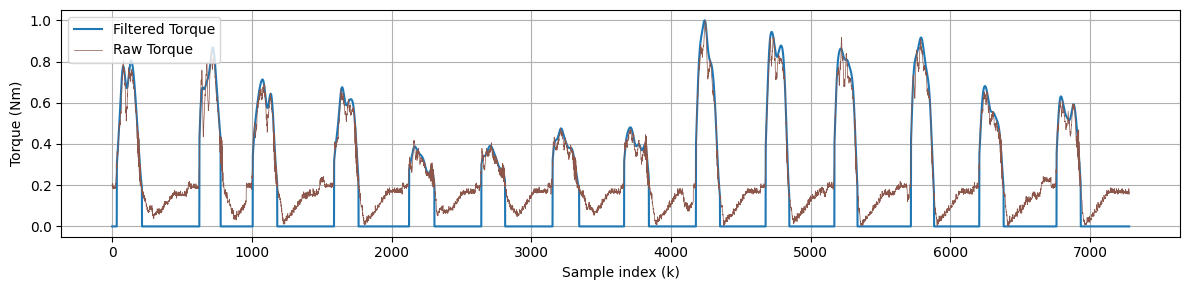

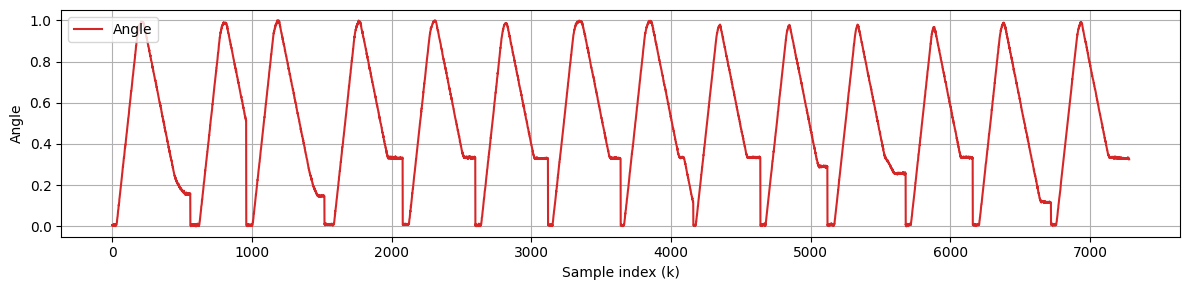

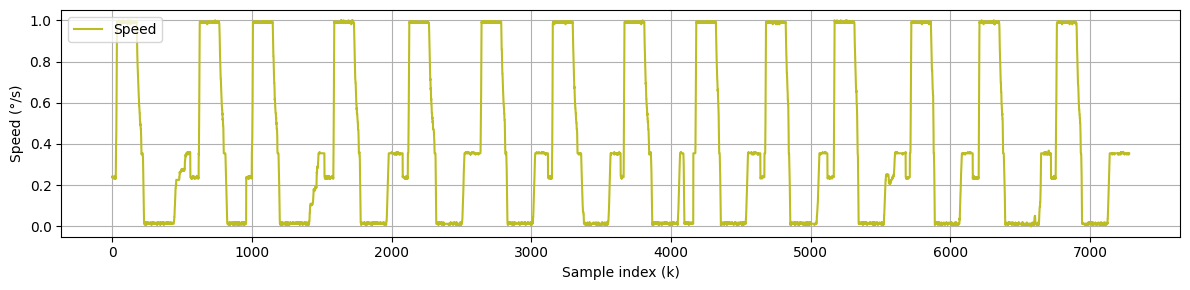

In [10]:
isoforce_py.plot_torque()
isoforce_py.plot_angle()
isoforce_py.plot_speed()


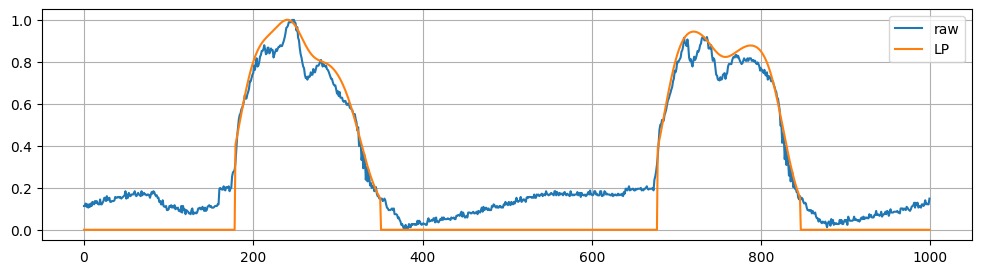

In [13]:
plt.figure(figsize=(12, 3))
plt.plot((isoforce_py.torque_raw[4000:5000]), label="raw")
plt.plot((isoforce_py.torque[4000:5000]), label="LP")
plt.legend()
plt.grid()

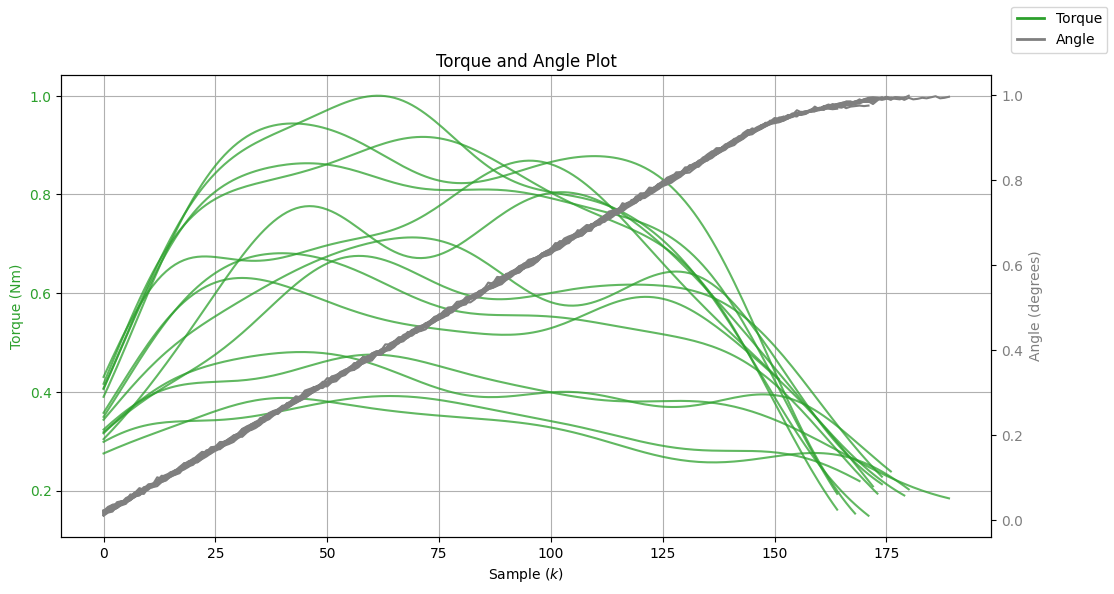

In [14]:
from matplotlib.lines import Line2D
fig, ax1 = plt.subplots(figsize=(12,6)) 

# Plot Torque on the primary y-axis
for idx in range(len(isoforce_py.torque_segments.keys())):
    ax1.plot(isoforce_py.torque_segments[f"T_seg_{idx}"], "C2", alpha=0.75)

ax1.set_xlabel("Sample ($k$)")
ax1.set_ylabel("Torque (Nm)", color="C2")
ax1.tick_params(axis="y", labelcolor="C2")
ax1.grid()

# Create a second y-axis for Angle
ax2 = ax1.twinx()  
for idx in range(len(isoforce_py.angle_segments.keys())):
    ax2.plot(isoforce_py.angle_segments[f"A_seg_{idx}"], "C7")

ax2.set_ylabel("Angle (degrees)", color="C7")
ax2.tick_params(axis="y", labelcolor="C7")

custom_lines = [
    Line2D([0], [0], color="C2", lw=2, label="Torque"),
    Line2D([0], [0], color="C7", lw=2, label="Angle")
]
fig.legend(handles=custom_lines, loc="upper right")


plt.title("Torque and Angle Plot")
plt.show()


## Synchronization between `IsoForceRaw` and `IsoForcePy`

In [15]:
len(isoforce_iso.torque_segments.keys()), len(isoforce_py.torque_segments.keys())


(14, 14)

In [16]:
from scipy.signal import resample


def resample_signals(iso_iso, iso_py, target_length=None):
    iso_iso = np.asarray(iso_iso)
    iso_py = np.asarray(iso_py)
    if target_length:
        print(f"Resample both signals to a length of {target_length} samples.")
        iso_py = resample(iso_py, num=target_length)
        iso_iso = resample(iso_iso, num=target_length)
        return iso_iso, iso_py
    else:
        target_length = max(len(iso_iso), len(iso_py))
        print(f"Resample both signals to a length of {target_length} samples.")
        if len(iso_iso) > len(iso_py):
            iso_py = resample(iso_py, num=target_length)
        elif len(iso_py) > len(iso_iso):
            iso_iso = resample(iso_iso, num=target_length)
        return iso_iso, iso_py


def detect_shift(signal1, signal2):
    N = max(len(signal1), len(signal2))
    corr = np.correlate(signal1, signal2, mode="full")
    lags = np.arange(-N + 1, N)

    max_corr_idx = np.argmax(corr)
    discrete_time_shift = lags[max_corr_idx]
    print(f"Discrete time shift of {discrete_time_shift}.")
    return discrete_time_shift

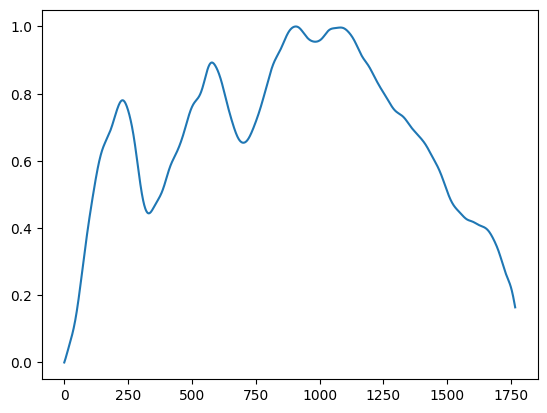

In [29]:
plt.plot(scale_to_range(isoforce_iso.torque_segments[f"T_seg_{1}"]))

Resample both signals to a length of 1813 samples.
Discrete time shift of 109.
109
Resample both signals to a length of 1500 samples.


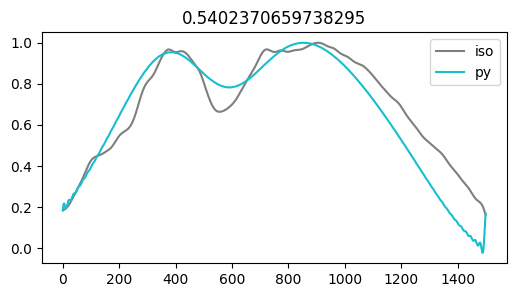

Resample both signals to a length of 1767 samples.
Discrete time shift of -3.
-3
Resample both signals to a length of 1500 samples.


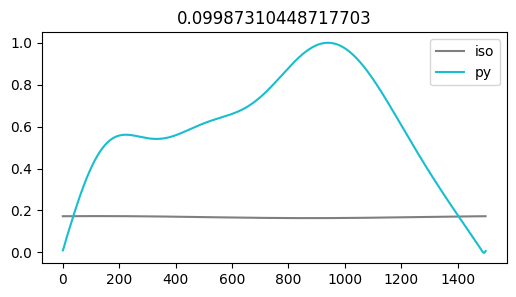

Resample both signals to a length of 1817 samples.
Discrete time shift of 81.
81
Resample both signals to a length of 1500 samples.


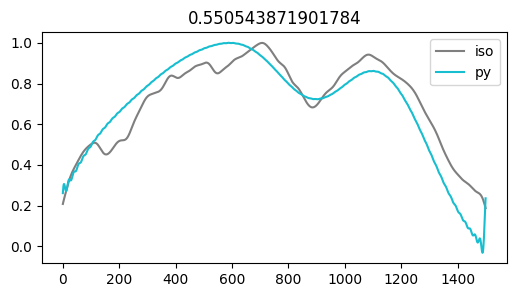

Resample both signals to a length of 1814 samples.
Discrete time shift of 71.
71
Resample both signals to a length of 1500 samples.


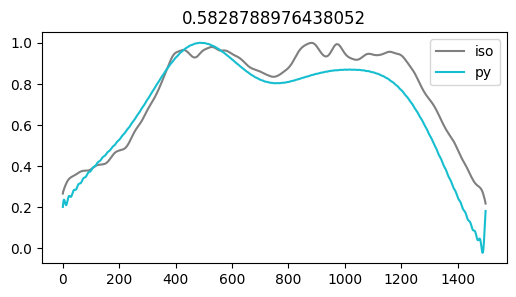

Resample both signals to a length of 1895 samples.
Discrete time shift of 127.
127
Resample both signals to a length of 1500 samples.


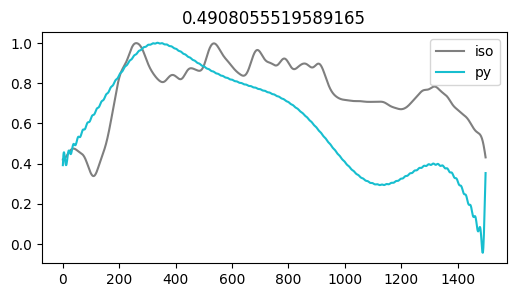

Resample both signals to a length of 1762 samples.
Discrete time shift of 102.
102
Resample both signals to a length of 1500 samples.


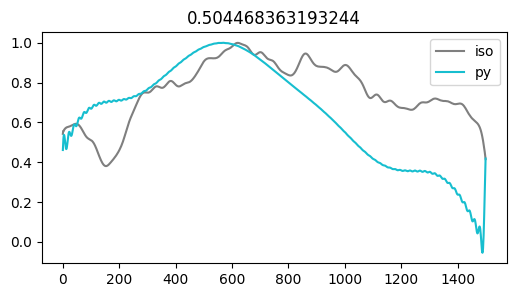

Resample both signals to a length of 1806 samples.
Discrete time shift of 121.
121
Resample both signals to a length of 1500 samples.


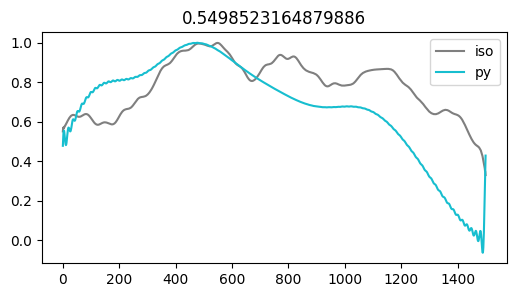

Resample both signals to a length of 1814 samples.
Discrete time shift of 66.
66
Resample both signals to a length of 1500 samples.


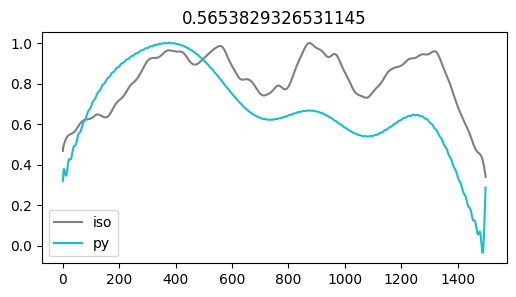

Resample both signals to a length of 1700 samples.
Discrete time shift of 87.
87
Resample both signals to a length of 1500 samples.


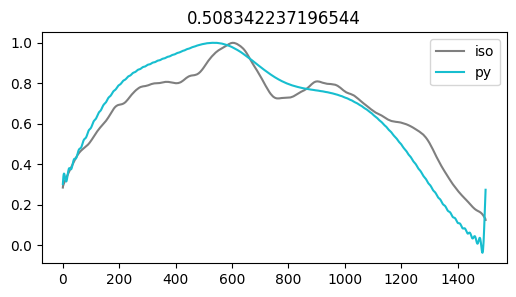

Resample both signals to a length of 1685 samples.
Discrete time shift of 76.
76
Resample both signals to a length of 1500 samples.


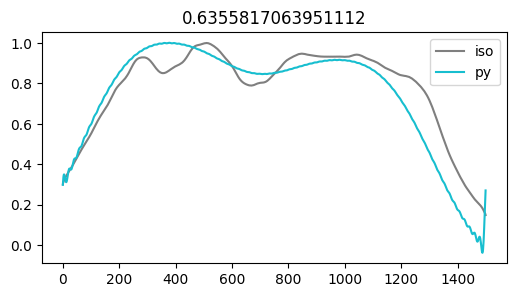

Resample both signals to a length of 1685 samples.
Discrete time shift of 68.
68
Resample both signals to a length of 1500 samples.


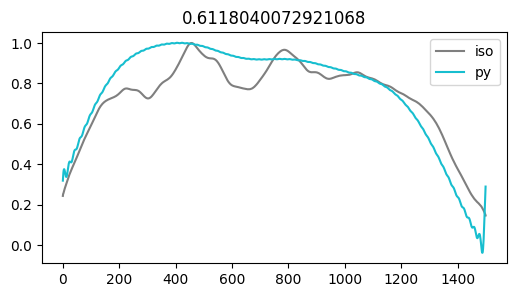

Resample both signals to a length of 1659 samples.
Discrete time shift of 74.
74
Resample both signals to a length of 1500 samples.


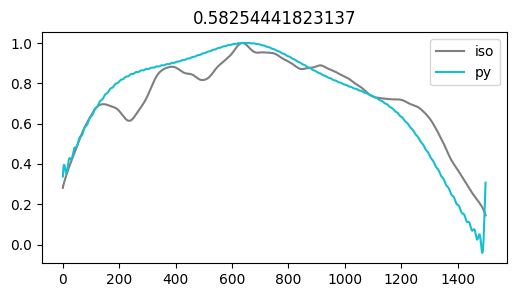

Resample both signals to a length of 1733 samples.
Discrete time shift of 90.
90
Resample both signals to a length of 1500 samples.


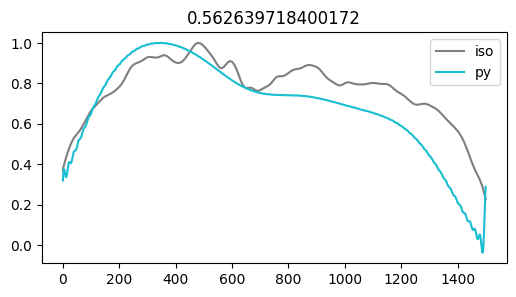

Resample both signals to a length of 1777 samples.
Discrete time shift of 82.
82
Resample both signals to a length of 1500 samples.


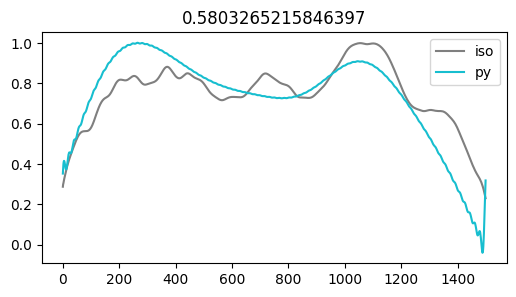

In [ ]:
for idx in range(
    min(
        len(isoforce_iso.torque_segments.keys()),
        len(isoforce_py.torque_segments.keys()),
    )
):
    # scale the amplitude rage to [0,1].
    iso_seg = scale_to_range(isoforce_iso.torque_segments[f"T_seg_{idx}"])
    py_seg = scale_to_range(isoforce_py.torque_segments[f"T_seg_{idx}"])
    
    # create two signals of same length and compute the phase shift.
    iso_seg_corr, py_seg_corr = resample_signals(iso_seg, py_seg)
    shift = detect_shift(iso_seg_corr, py_seg_corr)
    
    # resample the original, amplitude scaled signals to a constant lenght
    iso_seg, py_seg = resample_signals(iso_seg[shift:], py_seg, target_length=1500)

    plt.figure(figsize=(6, 3))
    plt.title(np.correlate(iso_seg, py_seg)[0] / len(iso_seg))
    # plt.show()
    plt.plot(iso_seg, "C7", label="iso")
    plt.plot(py_seg, "C9", label="py")
    plt.legend()
    plt.show()

In [33]:
for start, stop in zip(isoforce_py.start_idxs, isoforce_py.stop_idxs):
    print("from", isoforce_py.time[start], "to", isoforce_py.time[stop])
    print("Δt", isoforce_py.time[stop] - isoforce_py.time[start])

from 34 to 214
Δt 180
from 625 to 777
Δt 152
from 1007 to 1182
Δt 175
from 1589 to 1764
Δt 175
from 2126 to 2307
Δt 181
from 2643 to 2813
Δt 170
from 3153 to 3343
Δt 190
from 3665 to 3842
Δt 177
from 4179 to 4351
Δt 172
from 4678 to 4847
Δt 169
from 5170 to 5335
Δt 165
from 5718 to 5883
Δt 165
from 6207 to 6381
Δt 174
from 6760 to 6933
Δt 173
